<a href="https://colab.research.google.com/github/TranDucLongAIDHSPKTHY/DemoMovies/blob/main/Recommendation_systems_for_Movies_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Đọc file csv

In [ ]:
rating = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/movie-25M/ratings.csv')
movie = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/movie-25M/movies.csv')

In [ ]:
rating.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
movie.head(3)

#Giải thích dữ liệu & Tiền xử lý dữ liệu

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
# Kiểm tra các giá trị thiếu
print(rating.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Kiểm tra các giá trị trùng lặp
print(rating.duplicated().sum())

0


In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
# Kiểm tra các giá trị thiếu
print(movie.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [ ]:
# Kiểm tra các giá trị trùng lặp
print(movie.duplicated().sum())

0


In [ ]:
ratings = rating.head(100396)#25000094

In [ ]:
movies = movie.head(50000)

In [ ]:
# Kết hợp dữ liệu movies và ratings
merged = pd.merge(ratings, movies, left_on='movieId', right_on='movieId')
data = merged[['userId', 'movieId', 'rating']]

In [ ]:
data.head()

,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0


In [ ]:
data.info()

In [ ]:
# Đánh chỉ số cho user_id và movie_id
user_ids = data['userId'].unique().tolist()
movie_ids = data['movieId'].unique().tolist()
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [ ]:
# Thay thế user_id và movie_id bằng các chỉ số
data['user'] = data['userId'].map(user_id_to_index)
data['movie'] = data['movieId'].map(movie_id_to_index)

<ipython-input-63-331b79e951b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user'] = data['userId'].map(user_id_to_index)
<ipython-input-63-331b79e951b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['movie'] = data['movieId'].map(movie_id_to_index)


# Trực quan hóa dữ liệu

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-65-2d5f83185730>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='rating', palette='viridis')


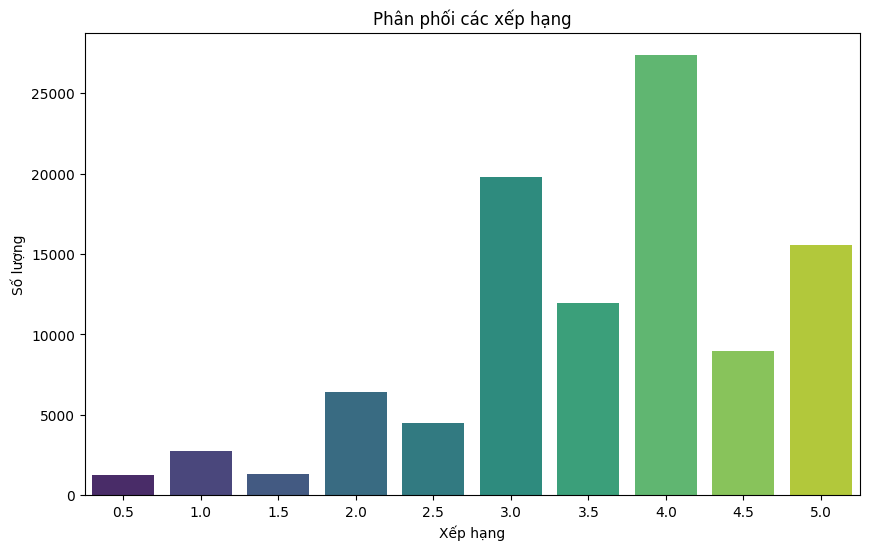

In [ ]:
#Biểu đồ phân phối xếp hạng của các bộ phim
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='rating', palette='viridis')
plt.title('Phân phối các xếp hạng')
plt.xlabel('Xếp hạng')
plt.ylabel('Số lượng')
plt.show()

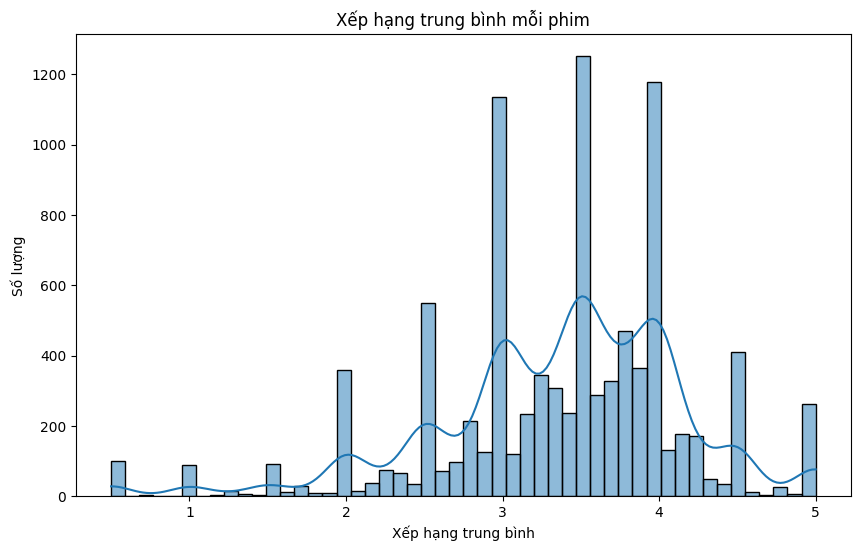

In [ ]:
# Tính trung bình xếp hạng cho mỗi phim
average_rating_per_movie = data.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_movie, bins=50, kde=True)
plt.title('Xếp hạng trung bình mỗi phim')
plt.xlabel('Xếp hạng trung bình')
plt.ylabel('Số lượng')
plt.show()

# Train & Test

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

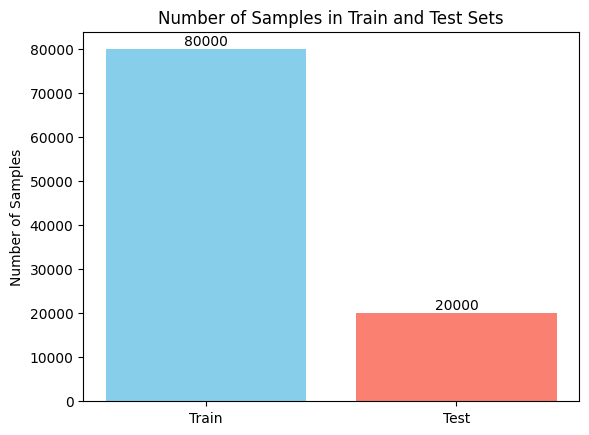

In [ ]:
# Đếm số lượng mẫu trong mỗi tập
train_count = len(train)
test_count = len(test)

In [ ]:
# Vẽ biểu đồ
labels = ['Train', 'Test']
counts = [train_count, test_count]

plt.bar(labels, counts, color=['skyblue', 'salmon'])

# Hiển thị số lượng mẫu trên đỉnh mỗi cột
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu trong các tập Train và Test')
plt.show()

# Build model Autuencoder & NCF_MLP

In [ ]:
# Định nghĩa dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = self.ratings.iloc[idx]['user']
        movie = self.ratings.iloc[idx]['movie']
        rating = self.ratings.iloc[idx]['rating']
        return torch.tensor(user), torch.tensor(movie), torch.tensor(rating, dtype=torch.float32)

In [ ]:
# Tạo dataset cho train và test
train_dataset = RatingsDataset(train)
test_dataset = RatingsDataset(test)

In [ ]:
# Tạo DataLoader để lấy các batch dữ liệu
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# Định nghĩa mô hình Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(Autoencoder, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 256)
        self.fc2 = nn.Linear(256, embedding_size * 2)
        self.fc3 = nn.Linear(embedding_size * 2, embedding_size * 2)
        self.fc4 = nn.Linear(embedding_size * 2, 256)
        self.fc5 = nn.Linear(256, 1)

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
# Định nghĩa mô hình MLP trong NCF
class NCF_MLP(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50, hidden_layers=[256, 128, 64]):
        super(NCF_MLP, self).__init__()

        # Tầng embedding cho user và movie
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Tầng fully connected với các hidden layers
        layers = []
        input_size = embedding_size * 2  # vì nối 2 embedding lại với nhau
        for hidden_layer_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_layer_size))
            layers.append(nn.ReLU()) #Hàm kích hoạt ReLU
            input_size = hidden_layer_size  # cập nhật kích thước đầu vào cho tầng tiếp theo

        # Sequential model cho MLP
        self.mlp_layers = nn.Sequential(*layers)

        # Tầng đầu ra
        self.output_layer = nn.Linear(hidden_layers[-1], 1) #Tầng đầu ra là một tầng fully connected với chỉ một neuron, mục tiêu là dự đoán rating từ đầu vào.

    def forward(self, user, movie):
        # Embedding user và movie
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)

        # Nối 2 embedding lại với nhau
        x = torch.cat([user_embedded, movie_embedded], dim=1)

        # Đi qua các tầng MLP
        x = self.mlp_layers(x)

        # Tầng đầu ra dự đoán rating
        x = self.output_layer(x)
        return x

In [ ]:
# Khởi tạo mô hình với optimizer (số lượng user và movie)
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 50
hidden_layers = [256, 128, 64]  # các tầng ẩn

In [ ]:
autoencoder = Autoencoder(num_users, num_movies, embedding_size)
ncf_mlp = NCF_MLP(num_users, num_movies, embedding_size, hidden_layers) #lựa chọn model để xây dựng hệ thống

In [ ]:
#Tải mô hình đã lưu
#autoencoder.load_state_dict(torch.load('/content/drive/My Drive/Project4_Trần Đức Long_124211/autoencoder_model.pth'))
#ncf_mlp.load_state_dict(torch.load('/content/drive/My Drive/Project4_Trần Đức Long_124211/ncf_mlp_model.pth'))


In [ ]:
# Hàm mục tiêu cho NCF: sử dụng MSE
criterion = nn.MSELoss()
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
ncf_optimizer = optim.Adam(ncf_mlp.parameters(), lr=0.001)

In [ ]:
# Huấn luyện mô hình Autoencoder
def train_autoencoder():
    autoencoder.train()
    train_loss = 0
    for user, movie, rating in train_loader:
        user = user.long()
        movie = movie.long()
        autoencoder_optimizer.zero_grad()
        output = autoencoder(user, movie)
        loss = criterion(output.view(-1), rating)
        loss.backward()
        autoencoder_optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [ ]:
# Hàm huấn luyện cho mô hình MLP
def train_ncf_mlp():
    ncf_mlp.train()
    train_loss = 0
    for user, movie, rating in train_loader:
        user = user.long()
        movie = movie.long()
        ncf_optimizer.zero_grad()
        output = ncf_mlp(user, movie)
        loss = criterion(output.view(-1), rating)
        loss.backward()
        ncf_optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)


In [ ]:
# Huấn luyện và đánh giá
for epoch in range(10):
    autoencoder_loss = train_autoencoder()
    ncf_mlp_loss= train_ncf_mlp()
    print(f'Epoch {epoch+1}: Autoencoder Loss: {autoencoder_loss:.4f}, NCF_MLP Loss: {ncf_mlp_loss:.4f}')

Epoch 1: Autoencoder Loss: 1.3953, NCF_MLP Loss: 1.4180
Epoch 2: Autoencoder Loss: 0.8515, NCF_MLP Loss: 0.8496
Epoch 3: Autoencoder Loss: 0.7909, NCF_MLP Loss: 0.7867
Epoch 4: Autoencoder Loss: 0.7503, NCF_MLP Loss: 0.7475
Epoch 5: Autoencoder Loss: 0.7206, NCF_MLP Loss: 0.7154
Epoch 6: Autoencoder Loss: 0.6977, NCF_MLP Loss: 0.6892
Epoch 7: Autoencoder Loss: 0.6683, NCF_MLP Loss: 0.6664
Epoch 8: Autoencoder Loss: 0.6439, NCF_MLP Loss: 0.6469
Epoch 9: Autoencoder Loss: 0.6261, NCF_MLP Loss: 0.6313
Epoch 10: Autoencoder Loss: 0.6091, NCF_MLP Loss: 0.6124


# Metrics RMSE & MAE

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for user, movie, rating in dataloader:
            user = user.long()
            movie = movie.long()
            output = model(user, movie)
            predictions.extend(output.numpy().flatten())
            actuals.extend(rating.numpy().flatten())

    # Tính toán RMSE và MAE
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    return rmse, mae

In [ ]:
autoencoder_rmse, autoencoder_mae = evaluate_model(autoencoder, test_loader)
ncf_rmse, ncf_mae = evaluate_model(ncf_mlp, test_loader)

print(f'Autoencoder RMSE: {autoencoder_rmse:.4f}, MAE: {autoencoder_mae:.4f}')
print(f'NCF_MLP RMSE: {ncf_rmse:.4f}, MAE: {ncf_mae:.4f}')

Autoencoder RMSE: 0.9242, MAE: 0.7219
NCF_MLP RMSE: 0.9100, MAE: 0.7056


# Cosine similarity

In [ ]:
# Hàm tính cosine similarity giữa các embeddings
def cosine_similarity_matrix(embeddings):
    # Chuẩn hóa embeddings về độ dài đơn vị
    embeddings = F.normalize(embeddings, p=2, dim=1)
    # Nhân ma trận embeddings với chính nó (transpose) để lấy cosine similarity
    similarity_matrix = torch.mm(embeddings, embeddings.t())
    return similarity_matrix

In [ ]:
# Hàm tính similarity cho tất cả các movie
def calculate_movie_similarity(model, num_movies):
    model.eval()
    with torch.no_grad():
        # Lấy movie embeddings
        movie_embeddings = model.movie_embedding.weight
        # Tính ma trận cosine similarity
        similarity_matrix = cosine_similarity_matrix(movie_embeddings)

    # Chuyển đổi ma trận thành numpy array để dễ xử lý và lưu trữ
    similarity_matrix_np = similarity_matrix.cpu().numpy()
    return similarity_matrix_np

In [ ]:
# Tính toán độ tương đồng giữa các phim
movie_similarity_matrix = calculate_movie_similarity(ncf_mlp, num_movies)

# Chuyển ma trận similarity thành DataFrame
movie_similarity_df = pd.DataFrame(movie_similarity_matrix, index=movie_ids, columns=movie_ids)

# Hàm gợi ý phim

In [ ]:
# Hàm gợi ý phim cho một người dùng cụ thể
def recommend_similar_movies(movie_id, num_recommendations=10):
    if movie_id not in movie_ids:
        raise ValueError(f"Movie ID {movie_id} không hợp lệ.")

    movie_idx = movie_id_to_index[movie_id]
    movie_similarities = movie_similarity_matrix[movie_idx]

    # Lấy các phim có độ tương đồng cao nhất
    top_movie_indices = movie_similarities.argsort()[-num_recommendations-1:-1][::-1]
    recommended_movie_ids = [movie_ids[i] for i in top_movie_indices]

    # Ánh xạ ID phim ra tên phim
    movie_id_to_title = dict(zip(movies['movieId'], movies['title']))
    recommended_movie_titles = [movie_id_to_title.get(movie_id, "Unknown") for movie_id in recommended_movie_ids]

    return recommended_movie_titles

In [ ]:
# Gợi ý phim tương tự cho một bộ phim cụ thể
movie_id = 99  # ID phim mà bạn muốn gợi ý các phim tương tự
similar_movies = recommend_similar_movies(movie_id)

print(f"Gợi ý phim tương tự cho Movie ID {movie_id}:")
for movie in similar_movies:
    print(f"- {movie}")

Gợi ý phim cho User ID 10:
- Bikini Beach (1964)
- Whiplash (2013)
- Freshman, The (1925)
- Ghost in the Shell 2.0 (2008)
- Born Free (1966)
- Eddie Murphy Raw (1987)
- Breaking the Waves (1996)
- Muscle Beach Party (1964)
- I Wish (Kiseki) (2011)
- Kaboom (2010)


In [ ]:
file_path = '/content/drive/My Drive/Project4_Trần Đức Long_124211/movie_similarity_real.pkl'

# Lưu DataFrame vào file .pkl
movie_similarity_df.to_pickle(file_path)

print("Đã lưu ma trận similarity vào file .pkl.")

In [ ]:
# Lưu mô hình Autoencoder
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/autoencoder_model_real.pth')

# Lưu mô hình NCF_MLP
torch.save(ncf_mlp.state_dict(), '/content/drive/My Drive/Project4_Trần Đức Long_124211/ncf_mlp_model_real.pth')

In [ ]:
file_path = '/content/drive/My Drive/Project4_Trần Đức Long_124211/data_real.pkl'

# Lưu DataFrame vào file .pkl
data.to_pickle(file_path)

print("Đã lưu ma trận similarity vào file .pkl.")

- Autoencoder RMSE: 0.9242, MAE: 0.7219
- NCF_MLP RMSE: 0.9100, MAE: 0.7056

Dataset: https://www.kaggle.com/datasets/garymk/movielens-25m-dataset/data